In [1]:
# Load single centre data

import numpy as np
import os  # Import the os library for file path operations

# Define common directory path
common_path = 'YOUR_PATH_HERE'

# Load files using common directory path
UoE_x = np.loadtxt(os.path.join(common_path, 'Uncorrected_MedianFiltered_SIZEMatched_UoE_x.csv'), delimiter=',')
UoE_y = np.loadtxt(os.path.join(common_path, 'Uncorrected_MedianFiltered_SIZEMatched_UoE_y.csv'), delimiter=',')
UoE_name = np.loadtxt(os.path.join(common_path, 'Uncorrected_MedianFiltered_SIZEMatched_UoE_name.csv'), delimiter=',')
UoE_wn = np.loadtxt(os.path.join(common_path, 'Uncorrected_MedianFiltered_SizeMatched_UoE_wn.csv'), delimiter=',')

# Create dictionary keys

Raw_labels = {
  "NSQ": 0,
  "IM": 1,
  "LGD": 2,
  "HGD": 3,
  "AC": 4
}

UoE_x.shape, UoE_y.shape, UoE_name.shape, UoE_wn.shape

Mounted at /content/drive


((192170, 891), (192170,), (192170,), (891,))

In [2]:
def truncate_spectra_to_region(wn, spectra, trunc_start = 400, trunc_end = 1800):
    """
    Function to truncate spectra within a specified region, default to the fingerprint region
    Inputs:
        wn - an array (vector) of the wavenumbers
        spectra - an array (matrix) of spectra (spectra in the rows)
        trunc_start - start of wavenumber region to be included
        trunc_end - end of wavenumber region to be included
    Outputs:

    """

    if trunc_start > trunc_end:
        print("ERROR: Start of region must be lower than end of region")
        pass

    closest_top_wn = min(wn, key=lambda x:abs(x-trunc_end))
    closest_bottom_wn = min(wn, key=lambda x:abs(x-trunc_start))

    max_wn = np.where(wn == closest_top_wn)
    min_wn = np.where(wn == closest_bottom_wn)

    trunc_spectra = spectra[:,np.squeeze(max_wn):np.squeeze(min_wn)]
    trunc_wn = wn[np.squeeze(max_wn):np.squeeze(min_wn)]

    return trunc_spectra, trunc_wn

import numpy as np

def norm_spectra(spec):
    """spec - a matrix of spectra of dimension: number of spectra x wavenumber"""
    """normed_spec = a matrix of 'individual' SNV normalised spectra"""

    normed_spec = np.zeros(spec.shape)

    for i in range(0, spec.shape[0]):
        normed_spec[i] = (spec[i] - np.mean(spec[i]))/np.std(spec[i])

    return normed_spec

In [3]:
# Define the CNN

# 3 layer

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 20, kernel_size=7, stride=1, padding=0),
            nn.BatchNorm1d(20),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=7, stride=3))
        self.layer2 = nn.Sequential(
            nn.Conv1d(20, 40, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm1d(40),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv1d(40, 40, kernel_size=3, stride=1, padding=0), #60
            nn.BatchNorm1d(40), #60
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=1))
        #self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(5480, 60) # To get the first number try running the model then when it spits out an error it will give you the shape you need
        self.fc2 = nn.Linear(60, 5)
        #4200 for untruncated, 4280 for truncated

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        #out = self.drop_out(out)
        #out = self.fc1(out)
        out = F.relu(self.fc1(out))
        out = F.dropout(out, 0.2)
        out = self.fc2(out)


        return out
        #return F.softmax(out, dim=1)


from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import numpy as np


class SpectralDataset(Dataset):
    """
    Builds a dataset of spectral data. Use idxs to specify which samples to use
    for dataset - this allows for random splitting into training, validation,
    and test sets. Instead of passing in filenames for X and y, we can also
    pass in numpy arrays directly.
    """
    def __init__(self, X_fn, y_fn, idxs=None, transform=None):
        if type(X_fn) == str:
            self.X = np.load(X_fn)
        else:
            self.X = X_fn
        if type(y_fn) == str:
            self.y = np.load(y_fn)
        else:
            self.y = y_fn
        if idxs is None: idxs = np.arange(len(self.y))
        self.idxs = idxs
        self.transform = transform

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, idx):
        i = self.idxs[idx]
        x, y = self.X[i], self.y[i]
        x = np.expand_dims(x, axis=0)
        if self.transform:
            x = self.transform(x)
        return (x, y)


### TRANSFORMS ###


class GetInterval(object):
    """
    Gets an interval of each spectrum.
    """
    def __init__(self, min_idx, max_idx):
        self.min_idx = min_idx
        self.max_idx = max_idx

    def __call__(self, x):
        x = x[:,self.min_idx:self.max_idx]
        return x


class ToFloatTensor(object):
    """
    Converts numpy arrays to float Variables in Pytorch.
    """
    def __call__(self, x):
        x = torch.from_numpy(x).float()
        return x


### TRANSFORMS ###


def spectral_dataloader(X_fn, y_fn, idxs=None, batch_size=10, shuffle=True,
    num_workers=4, min_idx=None, max_idx=None, sampler=None):
    """
    Returns a DataLoader with spectral data.
    """
    transform_list = []
    if min_idx is not None and max_idx is not None:
        transform_list.append(GetInterval(min_idx, max_idx))
    transform_list.append(ToFloatTensor())
    transform = transforms.Compose(transform_list)
    dataset = SpectralDataset(X_fn, y_fn, idxs=idxs, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, sampler=sampler)
    return dataloader


def spectral_dataloaders(X_fn, y_fn, n_train=None, p_train=0.8, p_val=0.1,
    n_test=None, batch_size=10, shuffle=True, num_workers=4, min_idx=None,
    max_idx=None):
    """
    Returns train, val, and test DataLoaders by splitting the dataset randomly.
    Can also take X_fn and y_fn as numpy arrays.
    """
    if type(y_fn) == str:
        idxs = np.arange(len(np.load(y_fn)))
    else:
        idxs = np.arange(len(y_fn))
    np.random.shuffle(idxs)
    if n_train is None: n_train = int(p_train * len(idxs))
    n_val = int(p_val * n_train)
    val_idxs, train_idxs = idxs[:n_val], idxs[n_val:n_train]
    if n_test is None: test_idxs = idxs[n_train:]
    else: test_idxs = idxs[n_train:n_train+n_test]
    trainloader = spectral_dataloader(X_fn, y_fn, train_idxs,
        batch_size=batch_size, shuffle=shuffle, num_workers=num_workers,
        min_idx=min_idx, max_idx=max_idx)
    valloader = spectral_dataloader(X_fn, y_fn, val_idxs,
        batch_size=batch_size, shuffle=shuffle, num_workers=num_workers,
        min_idx=min_idx, max_idx=max_idx)
    testloader = spectral_dataloader(X_fn, y_fn, test_idxs,
        batch_size=batch_size, shuffle=shuffle, num_workers=num_workers,
        min_idx=min_idx, max_idx=max_idx)
    return (trainloader, valloader, testloader)

In [4]:
# Custom class for stratification by group.
# Taken from: https://www.kaggle.com/realsid/stratifiedgroupkfold-using-sklearn

from sklearn.model_selection._split import _BaseKFold, _RepeatedSplits
from sklearn.utils.validation import check_random_state, column_or_1d
from sklearn.utils.multiclass import type_of_target
from collections import defaultdict

class StratifiedGroupKFold(_BaseKFold):
    """Stratified K-Folds iterator variant with non-overlapping groups.
    This cross-validation object is a variation of StratifiedKFold attempts to
    return stratified folds with non-overlapping groups. The folds are made by
    preserving the percentage of samples for each class.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    The difference between GroupKFold and StratifiedGroupKFold is that
    the former attempts to create balanced folds such that the number of
    distinct groups is approximately the same in each fold, whereas
    StratifiedGroupKFold attempts to create folds which preserve the
    percentage of samples for each class as much as possible given the
    constraint of non-overlapping groups between splits.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of folds. Must be at least 2.
    shuffle : bool, default=False
        Whether to shuffle each class's samples before splitting into batches.
        Note that the samples within each split will not be shuffled.
        This implementation can only shuffle groups that have approximately the
        same y distribution, no global shuffle will be performed.
    random_state : int or RandomState instance, default=None
        When `shuffle` is True, `random_state` affects the ordering of the
        indices, which controls the randomness of each fold for each class.
        Otherwise, leave `random_state` as `None`.
        Pass an int for reproducible output across multiple function calls.
        See :term:`Glossary <random_state>`.
    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.model_selection import StratifiedGroupKFold
    >>> X = np.ones((17, 2))
    >>> y = np.array([0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    >>> groups = np.array([1, 1, 2, 2, 3, 3, 3, 4, 5, 5, 5, 5, 6, 6, 7, 8, 8])
    >>> cv = StratifiedGroupKFold(n_splits=3)
    >>> for train_idxs, test_idxs in cv.split(X, y, groups):
    ...     print("TRAIN:", groups[train_idxs])
    ...     print("      ", y[train_idxs])
    ...     print(" TEST:", groups[test_idxs])
    ...     print("      ", y[test_idxs])
    TRAIN: [1 1 2 2 4 5 5 5 5 8 8]
           [0 0 1 1 1 0 0 0 0 0 0]
     TEST: [3 3 3 6 6 7]
           [1 1 1 0 0 0]
    TRAIN: [3 3 3 4 5 5 5 5 6 6 7]
           [1 1 1 1 0 0 0 0 0 0 0]
     TEST: [1 1 2 2 8 8]
           [0 0 1 1 0 0]
    TRAIN: [1 1 2 2 3 3 3 6 6 7 8 8]
           [0 0 1 1 1 1 1 0 0 0 0 0]
     TEST: [4 5 5 5 5]
           [1 0 0 0 0]
    Notes
    -----
    The implementation is designed to:
    * Mimic the behavior of StratifiedKFold as much as possible for trivial
      groups (e.g. when each group contains only one sample).
    * Be invariant to class label: relabelling ``y = ["Happy", "Sad"]`` to
      ``y = [1, 0]`` should not change the indices generated.
    * Stratify based on samples as much as possible while keeping
      non-overlapping groups constraint. That means that in some cases when
      there is a small number of groups containing a large number of samples
      the stratification will not be possible and the behavior will be close
      to GroupKFold.
    See also
    --------
    StratifiedKFold: Takes class information into account to build folds which
        retain class distributions (for binary or multiclass classification
        tasks).
    GroupKFold: K-fold iterator variant with non-overlapping groups.
    """

    def __init__(self, n_splits=5, shuffle=False, random_state=None):
        super().__init__(n_splits=n_splits, shuffle=shuffle,
                         random_state=random_state)

    def _iter_test_indices(self, X, y, groups):
        # Implementation is based on this kaggle kernel:
        # https://www.kaggle.com/jakubwasikowski/stratified-group-k-fold-cross-validation
        # and is a subject to Apache 2.0 License. You may obtain a copy of the
        # License at http://www.apache.org/licenses/LICENSE-2.0
        # Changelist:
        # - Refactored function to a class following scikit-learn KFold
        #   interface.
        # - Added heuristic for assigning group to the least populated fold in
        #   cases when all other criteria are equal
        # - Swtch from using python ``Counter`` to ``np.unique`` to get class
        #   distribution
        # - Added scikit-learn checks for input: checking that target is binary
        #   or multiclass, checking passed random state, checking that number
        #   of splits is less than number of members in each class, checking
        #   that least populated class has more members than there are splits.
        rng = check_random_state(self.random_state)
        y = np.asarray(y)
        type_of_target_y = type_of_target(y)
        allowed_target_types = ('binary', 'multiclass')
        if type_of_target_y not in allowed_target_types:
            raise ValueError(
                'Supported target types are: {}. Got {!r} instead.'.format(
                    allowed_target_types, type_of_target_y))

        y = column_or_1d(y)
        _, y_inv, y_cnt = np.unique(y, return_inverse=True, return_counts=True)
        if np.all(self.n_splits > y_cnt):
            raise ValueError("n_splits=%d cannot be greater than the"
                             " number of members in each class."
                             % (self.n_splits))
        n_smallest_class = np.min(y_cnt)
        if self.n_splits > n_smallest_class:
            warnings.warn(("The least populated class in y has only %d"
                           " members, which is less than n_splits=%d."
                           % (n_smallest_class, self.n_splits)), UserWarning)
        n_classes = len(y_cnt)


        _, groups_inv, groups_cnt = np.unique(
            groups, return_inverse=True, return_counts=True)
        y_counts_per_group = np.zeros((len(groups_cnt), n_classes))
        for class_idx, group_idx in zip(y_inv, groups_inv):
            y_counts_per_group[group_idx, class_idx] += 1

        y_counts_per_fold = np.zeros((self.n_splits, n_classes))
        groups_per_fold = defaultdict(set)

        if self.shuffle:
            rng.shuffle(y_counts_per_group)

        # Stable sort to keep shuffled order for groups with the same
        # class distribution variance
        sorted_groups_idx = np.argsort(-np.std(y_counts_per_group, axis=1),
                                       kind='mergesort')

        for group_idx in sorted_groups_idx:
            group_y_counts = y_counts_per_group[group_idx]
            best_fold = self._find_best_fold(
                y_counts_per_fold=y_counts_per_fold, y_cnt=y_cnt,
                group_y_counts=group_y_counts)
            y_counts_per_fold[best_fold] += group_y_counts
            groups_per_fold[best_fold].add(group_idx)

        for i in range(self.n_splits):
            test_indices = [idx for idx, group_idx in enumerate(groups_inv)
                            if group_idx in groups_per_fold[i]]
            yield test_indices

    def _find_best_fold(
            self, y_counts_per_fold, y_cnt, group_y_counts):
        best_fold = None
        min_eval = np.inf
        min_samples_in_fold = np.inf
        for i in range(self.n_splits):
            y_counts_per_fold[i] += group_y_counts
            # Summarise the distribution over classes in each proposed fold
            std_per_class = np.std(
                y_counts_per_fold / y_cnt.reshape(1, -1),
                axis=0)
            y_counts_per_fold[i] -= group_y_counts
            fold_eval = np.mean(std_per_class)
            samples_in_fold = np.sum(y_counts_per_fold[i])
            is_current_fold_better = (
                fold_eval < min_eval or
                np.isclose(fold_eval, min_eval)
                and samples_in_fold < min_samples_in_fold
            )
            if is_current_fold_better:
                min_eval = fold_eval
                min_samples_in_fold = samples_in_fold
                best_fold = i
        return best_fold

def get_predictions(model, dataloader, cuda, get_probs=False):
    preds = []
    model.eval()
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        if cuda: inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs), Variable(targets.long())
        outputs = model(inputs)
        if get_probs:
            probs = torch.nn.functional.softmax(outputs, dim=1)
            if cuda: probs = probs.data.cpu().numpy()
            else: probs = probs.data.numpy()
            preds.append(probs)
        else:
            _, predicted = torch.max(outputs.data, 1)
            if cuda: predicted = predicted.cpu()
            preds += list(predicted.numpy().ravel())
    if get_probs:
        return np.vstack(preds)
    else:
        return np.array(preds)

In [5]:
def plot_learning_curve(train_list, test_list, epochs):

    """
    Function to plot train and test learning curves, where train score calculated per batch, test score per epoch
    Inputs:
        train_list - List of training scores per batch.
        test_list - List of test scores per epoch
        epochs - Integer number of epochs
    Outputs:
        plt.show() - learning curve
    """

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twiny()

    x1 = np.linspace(0, len(train_list), len(train_list))
    x2 = np.linspace(0, len(train_list), len(test_list))

    ax1.plot(x1,train_list)
    ax1.plot(x2,test_list)
    ax1.set_xlabel("Batch")
    ax1.set_ylabel("Accuracy")

    batch_list = np.linspace(0, x1.shape[0], epochs)
    batch_labels = [0,1,2,3,4]

    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(batch_list)
    ax2.set_xticklabels(batch_labels)
    ax2.set_xlabel("Epoch")

    plt.show()

from collections import Counter

def get_data_weights(train_data):
    """
    Function to extract the class distribution of a dataset and
    return those as weights reasy for input into a pytorch optimiser
    Input:
        train_data - the labels of the data from which to extract class distribution
    Output:
        max_label / torch.tensor([all_values]) - the realtive weights based on class distribution.
        The largest class will have a weight of one. The smallest class will have the largest weight.
    """
    from collections import Counter

    train_count = Counter(train_data)

    key_max = max(train_count.keys(), key=(lambda k: train_count[k]))
    max_label = train_count[key_max]

    all_values = np.array([train_count[k] for k in sorted(train_count.keys())]).flatten()
    all_values

    return max_label / torch.tensor([all_values])

In [6]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def train_cnn(model, X_train, y_train, X_test, y_test, learning_rate = 0.0001, beta1 = 0.9, beta2 = 0.999, num_epochs = 30, batch_size = 16, early_stop = 5,weightedLoss = False, learning_curves = True, cuda = False):

    train_loader = spectral_dataloader(X_train,y_train,batch_size = batch_size, shuffle=True) # requires dataloader functions
    test_loader = spectral_dataloader(X_test,y_test,batch_size = batch_size, shuffle=False)

    total_step = len(train_loader)
    loss_list = []
    acc_list = []
    test_acc_list = []
    test_logloss = []
    test_accuracy = []

            # Loss and optimizer

  #torch.manual_seed(3407) # If we want to fix random seed
    model = model() #this should be called before running the function so is not needed here
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    criterion = nn.CrossEntropyLoss()
    if weightedLoss:
        weight = np.squeeze(get_data_weights(y_train)).to(device) # Need to send all variables used in optimisation to the GPU, including this weights
        criterion = nn.CrossEntropyLoss(weight=weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(beta1, beta2))
    cuda = torch.cuda.is_available()

    if cuda:
      model.cuda()

    # early stopping set-up
    best_val = 0
    no_improvement = 0
    max_no_improvement = early_stop

    # Train the model
    for epoch in range(num_epochs):
        model.train()
        test_outputs_list = []
        test_predicted_list = []
        test_labels_list = []
        for i, (spectra, labels) in enumerate(train_loader):
            spectra, labels = spectra.cuda(), labels.cuda()
            # Run the forward pass

            outputs = model(spectra)
            loss = criterion(outputs, labels.long())
            loss_list.append(loss.item())

            # Backprop and perform Adam optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track the accuracy
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            acc_list.append(correct / total)

            if (i + 1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.3f}, Training Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), (correct / total) * 100))

                # Test the model
        print('Testing epoch {}'.format(epoch + 1))
        model.eval()
        with torch.no_grad():
            test_correct = 0
            test_total = 0
            for test_spectra, test_labels in test_loader:
                test_spectra, test_labels = test_spectra.cuda(), test_labels.cuda()
                test_outputs = model(test_spectra)
                test_outputs_list.append(test_outputs)
                test_labels_list.append(test_labels)
                _, test_predicted = torch.max(test_outputs.data, 1)
                test_predicted_list.append(test_predicted)
                test_total += test_labels.size(0)
                test_correct += (test_predicted == test_labels).sum().item()
                acc_te = test_correct / test_total
            test_acc_list.append(acc_te)

            print('Epoch {}: Test Accuracy {} %'.format(epoch+1,(acc_te) * 100))


                # Check performance for early stopping
        if acc_te > best_val or epoch == 0:
            best_val = acc_te
            no_improvement = 0
        else:
            no_improvement += 1
        if no_improvement >= max_no_improvement:
            print('Finished early after {} epochs!'.format(epoch+1))
            break

    # Final train score on a single batch
    train_log_loss, train_accuracy, _ = test_a_batch(model ,X_train, y_train, batch_size )

    # Final test score on a single batch
    test_log_loss, test_accuracy, con_mat = test_a_batch(model ,X_test, y_test, batch_size )

    print('Final Training Accuracy {} %'.format((train_accuracy) * 100))
    print('Final Test Accuracy {} %'.format((test_accuracy) * 100))

    if learning_curves:
        plot_learning_curve(acc_list, test_acc_list, epoch)

    return model, con_mat, test_log_loss, test_accuracy, train_log_loss, train_accuracy, test_outputs_list, test_predicted_list


In [7]:
def test_a_batch(model, X, y, cuda = True, batch_size = 16):

    """
    Function to take in a Pytorch neural network and some data and output the accuracy,
    confusion matrix and log loss

    Inputs:
        model - pytorch model
        X - data inputs compatible with the above model
        y - data labels
        batch_size - set low to ensure compatability even with poor memory CPUs

    Outputs:
        test_log_loss - log loss
        test_accuracy - accuracy
        con_mat - confusion matrix

    """

    test_loader = spectral_dataloader(X, y, batch_size = batch_size, shuffle=False)

    y_test_clas = get_predictions(model, test_loader, cuda, get_probs=False)
    y_test_pred = get_predictions(model, test_loader, cuda, get_probs=True)

    test_log_loss = metrics.log_loss(y, y_test_pred, labels = np.unique(y_test))
    test_accuracy = metrics.accuracy_score(y, y_test_clas)
    con_mat = confusion_matrix(y, y_test_clas)

    return test_log_loss, test_accuracy, con_mat

In [8]:
# Load Thunder SVM to allow SVM computation on the gpu

!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!ls
!dpkg -i cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!ls /var/cuda-repo-9-0-local | grep .pub
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
!apt-get update
!sudo apt-get install cuda-9.0
!pip install thundersvm

--2023-12-24 18:06:40--  https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
Resolving developer.nvidia.com (developer.nvidia.com)... 152.199.39.144
Connecting to developer.nvidia.com (developer.nvidia.com)|152.199.39.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.nvidia.com/downloads/compute/cuda/9.0/prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb [following]
--2023-12-24 18:06:41--  https://developer.nvidia.com/downloads/compute/cuda/9.0/prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
Reusing existing connection to developer.nvidia.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.0/secure/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64.deb?7C1rzSELH77Jm0H4yfE8tfStNNNnxfN4Z9fkp64vC0irP7T6_Vc_OvnVC8P-YObngFF4PYwdqo8bTtCzj5SMD

KeyboardInterrupt: ignored

In [ ]:
def truncate_spectra(wn, spectra, trunc_region, wavenumber_shift = 0):
    """Function truncate spectra to a common axis
    Inputs:
            wn - a vector containg the wavenumbers
            spectrum - the spectrum to be transformed
            trunc_region - the amount to shave off from each end of the spectrum
            wavenumber_shift - adds an amount of random wavenumber shifting
    Outputs:
            trunc_spec - the truncated spectrum
            trunc_wn - the truncated wavenumber axis
    Because two outputs are specified, a tuple containing both will be given if the
    function output is assigned only to a single variable
    """

    trunc_spectra = np.copy(spectra)

    if wavenumber_shift != 0:
        for i in range(0, trunc_spectra.shape[0]):
            trunc_spectra[i] = np.roll(spectra[i], wavenumber_shift)

    trunc_spectra = trunc_spectra[:,trunc_region:-trunc_region]
    trunc_wn = wn[trunc_region:-trunc_region]

    return trunc_spectra, trunc_wn

In [ ]:
# Visualise the perturbations

import matplotlib.pyplot as plt

pheny_peak = []
test_range = 5

normed_centre = norm_spectra(UoE_x)
truncated_x, truncated_wn = truncate_spectra(UoE_wn, normed_centre, test_range , wavenumber_shift = 0)

for shift in range(-test_range,test_range+1):
    X_test = truncate_spectra(UoE_wn, normed_centre, test_range , wavenumber_shift = shift)
    plt.plot(truncated_wn[604:620], X_test[0][9,604:620])
    print("Shift: {} Phenylalanine peak:{}".format(shift,truncated_wn[604:620][np.argmax(X_test[0][9,604:620])]))
    pheny_peak.append(truncated_wn[604:620][np.argmax(X_test[0][9,604:620])])

plt.axvline(x=1001.91015625, color='k', linestyle='--')
plt.ylabel("Intensity (A.U.)")
plt.xlabel(r'$\Delta cm^{-1}$')
plt.show()

In [ ]:
from thundersvm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import metrics
from sklearn.decomposition import PCA

lda_accuracy_by_order = []
lda_logloss_by_order = []
svm_accuracy_by_order = []
svm_logloss_by_order = []
cnn_accuracy_by_order = []
cnn_logloss_by_order = []

# Hyperparameters
batch_size = 184
n_epochs = 30
num_classes = 5
learning_rate = 5e-05

test_range = 5
counter = 0
n_repeats = 5
folds = 3
best_pc = 11
c = 0.9
gamma = 0.01

lda_no_noise_acc = []
svm_no_noise_acc = []
cnn_no_noise_acc = []

while counter < n_repeats*folds:

    sgkf = StratifiedGroupKFold(folds, shuffle = True)
    print("Fold:{}".format(counter+1))

    for train_index, test_index in sgkf.split(UoE_x, UoE_y, UoE_name):

        X_train, X_test = UoE_x[train_index], UoE_x[test_index]
        y_train, y_test = UoE_y[train_index], UoE_y[test_index]
        group_train = UoE_name[train_index]

        print(np.unique(y_train))
        print(np.unique(y_test))
        if len(np.unique(y_train)) != len(np.unique(UoE_y)) or len(np.unique(y_test)) != len(np.unique(UoE_y)):
          print("Skipping Fold due to indaquate training or testing classes")
          break

        counter = counter+1

        X_train, X_train_wn = truncate_spectra(UoE_wn, X_train, test_range , wavenumber_shift = 0)
        X_test_outer, X_test_wn = truncate_spectra(UoE_wn, X_test, test_range , wavenumber_shift = 0)

        X_train = norm_spectra(X_train)
        X_test_outer = norm_spectra(X_test_outer)

            # Train PCA-LDA
        print("Training PCA-LDA")

        pca = PCA(n_components = 11) 
        lda = LDA()

        X_train_pc = pca.fit_transform(X_train)
        lda.fit(X_train_pc, np.squeeze(y_train))

        lda_test_logloss = []
        lda_test_accuracy = []

            # Train SVM
        print("Training SVM")
        svm = SVC(probability = True, kernel='rbf', C = c, gamma = gamma)
        svm.fit(X_train, np.squeeze(y_train))

        svm_test_logloss = []
        svm_test_accuracy = []

            # Train CNN
        print("Training CNN")
        temp_X_test = norm_spectra(X_test_outer) # Take a temp test set which has not had noise added for the training process
        trained_ConvNet, _, _, acc, _, _, _, _ = train_cnn(ConvNet, X_train, y_train, temp_X_test, y_test, learning_rate = learning_rate, num_epochs = n_epochs, batch_size = batch_size, early_stop = 5, weightedLoss = False, learning_curves = False, cuda = True)
        cnn_test_logloss = []
        cnn_test_accuracy = []

        for shift in range(-test_range,test_range+1):
            print("Testing: Shift Factor level {}".format(shift))

            X_test_scaled, X_test_wn = truncate_spectra(UoE_wn, X_test, test_range , wavenumber_shift = shift)
            X_test_scaled_normed = norm_spectra(X_test_scaled)

                # LDA test
            X_test_pca = pca.transform(X_test_scaled_normed)
            outer_y_test_clas = lda.predict(X_test_pca)
            acc = metrics.accuracy_score(np.squeeze(y_test), outer_y_test_clas )
            lda_test_accuracy.append(acc)

                # SVM test
            outer_y_test_clas = svm.predict(X_test_scaled_normed)
            acc = metrics.accuracy_score(np.squeeze(y_test), outer_y_test_clas )
            svm_test_accuracy.append(acc)

                # CNN test

            _, acc, _ = test_a_batch(trained_ConvNet, X_test_scaled_normed, y_test )
            cnn_test_logloss.append(ll)
            cnn_test_accuracy.append(acc)


        lda_accuracy_by_order.append( lda_test_accuracy )
        svm_accuracy_by_order.append( svm_test_accuracy )
        cnn_accuracy_by_order.append( cnn_test_accuracy )


<ipython-input-24-c4a44966d543>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--go" (-> color='g'). The keyword argument will take precedence.
  plt.errorbar(shift_range, y=np.mean(lda_accuracy_by_order, axis=0), yerr=np.std(lda_accuracy_by_order, axis=0), fmt='--go', ecolor='lightgreen', color='green', label='PCA LDA', capsize=5)
<ipython-input-24-c4a44966d543>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--ro" (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(shift_range_minus, y=np.mean(svm_accuracy_by_order, axis=0), yerr=np.std(svm_accuracy_by_order, axis=0), fmt='--ro', ecolor='lightcoral', color='red', label='SVM', capsize=5)
<ipython-input-24-c4a44966d543>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--bo" (-> color='b'). The keyword argument will take precedence.
  plt.errorbar(shift_range_plus, y=np.

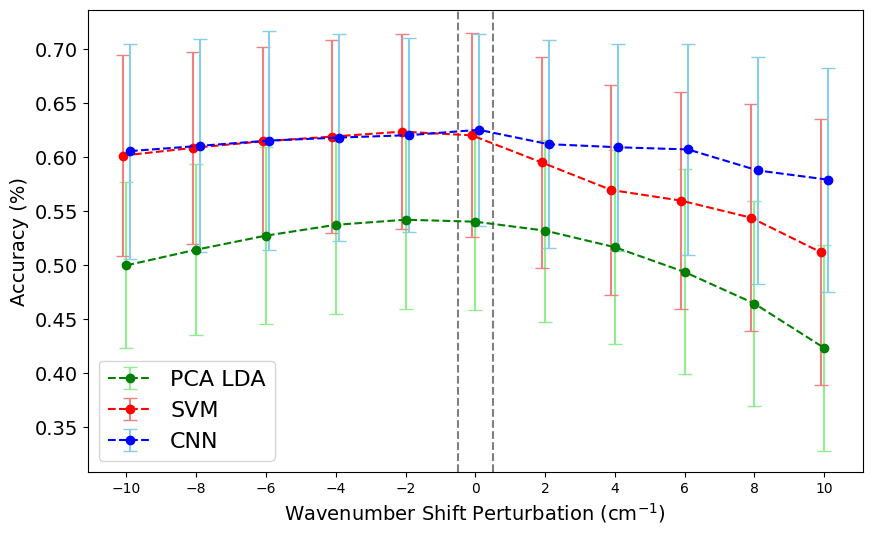

In [ ]:
shift_range = [-10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10]

shift_range_minus = [x - 0.1 for x in shift_range]
shift_range_plus = [x + 0.1 for x in shift_range]

plt.figure(figsize=(10, 6))
plt.errorbar(shift_range, y=np.mean(lda_accuracy_by_order, axis=0), yerr=np.std(lda_accuracy_by_order, axis=0), fmt='--go', ecolor='lightgreen', color='green', label='PCA LDA', capsize=5)
plt.errorbar(shift_range_minus, y=np.mean(svm_accuracy_by_order, axis=0), yerr=np.std(svm_accuracy_by_order, axis=0), fmt='--ro', ecolor='lightcoral', color='red', label='SVM', capsize=5)
plt.errorbar(shift_range_plus, y=np.mean(cnn_accuracy_by_order, axis=0), yerr=np.std(cnn_accuracy_by_order, axis=0), fmt='--bo', ecolor='skyblue', color='blue', label='CNN', capsize=5)
plt.xlabel('Wavenumber Shift Perturbation (cm$^{-1}$)', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.xticks(shift_range)
plt.yticks(fontsize=14)
plt.legend(loc = 'lower left', fontsize="16")
plt.axvline(x=0.5, color='black', linestyle='--', alpha=0.5)
plt.axvline(x=-0.5, color='black', linestyle='--', alpha=0.5)
plt.savefig("HiRes_Wavenumber_Perturbation", dpi=300)
plt.show()